# Instalação de Bibliotecas
Este bloco instala todas as bibliotecas necessárias para executar o projeto. Isso inclui bibliotecas para aprendizado de máquina (scikit-learn, h2o), manipulação de dados (pandas, numpy), visualização de dados (matplotlib, seaborn), e outras ferramentas auxiliares (mlflow para rastreamento de experimentos, pydotplus para visualização de árvores, six para compatibilidade Python 2 e 3)

In [1]:
!pip install scikit-learn==1.4.2
!apt-get install default-jre
!java -version
!pip install h2o
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install mlflow
!pip install pydotplus
!pip install six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  default-jre-headless fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  default-jre default-jre-headless fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
0 upgraded, 12 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,720 kB of archives.
After this operation, 12.7 MB of additional disk 

# Importação de Bibliotecas e Inicialização do H2O
Este bloco importa as bibliotecas necessárias para o projeto. A inicialização da instância H2O prepara o ambiente para a execução de AutoML, que é uma alternativa ao auto-sklearn que não é compatível com a versão atual do Python no Google Colab.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlflow import log_metric, log_param, start_run, end_run
from sklearn.cluster import KMeans

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16; OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk1_jtoyq
  JVM stdout: /tmp/tmpk1_jtoyq/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk1_jtoyq/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_30gdb2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# Carregamento e Preparação dos Dados
Carrega os dados de um arquivo CSV e prepara-os para análise, tratando valores faltantes e especificando as variáveis de interesse (features e target). Isso é essencial para garantir que os dados estejam prontos para serem usados nos modelos de machine learning.

In [3]:
df = pd.read_csv('updated_players_data.csv')
df['assists'] = df['assists'].fillna(0)

X = df[['goals', 'expectedGoals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage']]
y = df['rating']

# Divisão dos Dados
Divide os dados em conjuntos de treinamento, validação e teste, permitindo uma avaliação robusta do desempenho do modelo em dados não vistos durante o treinamento. Esta prática é crucial para evitar o overfitting e garantir que o modelo generalize bem para novos dados.

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Seleção e Configuração dos Modelos
Define quatro tipos de modelos de regressão e configura uma grade de hiperparâmetros para cada um, preparando-os para a otimização de hiperparâmetros via GridSearchCV. A seleção de modelos e parâmetros é fundamental para encontrar a configuração que oferece o melhor desempenho.

In [5]:
models = {
    "Random Forest": RandomForestRegressor(),
    "SVM": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "Linear Regression": LinearRegression()
}

param_grid = {
    "Random Forest": {"n_estimators": [10, 50, 100], "max_depth": [None, 10, 20], "min_samples_split": [2, 10]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ['rbf', 'linear']},
    "Decision Tree": {"max_depth": [None, 10, 20], "min_samples_split": [2, 10]},
    "Linear Regression": {}
}

# Treinamento e Avaliação dos Modelos
Utiliza GridSearchCV para encontrar o melhor conjunto de hiperparâmetros para cada modelo, avaliando-os com base no erro quadrático médio negativo (MSE). Registra os resultados usando MLFlow, o que ajuda no rastreamento de experimentos e comparação de desempenhos entre diferentes configurações de modelo.

In [6]:
start_run()
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_val, y_val)
    best_models[name] = grid_search.best_estimator_
    log_param(name, grid_search.best_params_)
    mse = -grid_search.best_score_
    log_metric(name + "_MSE", mse)
end_run()

# AutoML do H2O
Executa o AutoML do H2O, uma ferramenta poderosa que automatiza grande parte do processo de modelagem, incluindo a seleção e otimização de modelos. Isso é particularmente útil quando não se pode usar o auto-sklearn devido a incompatibilidades de versão.

In [7]:
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))

# Definindo 'x' e 'y' para o treinamento do modelo
x = train_h2o.columns
y = "rating"  # Nome da coluna alvo
x.remove(y)

# Configurando e treinando o AutoML
aml = H2OAutoML(max_runtime_secs=600, seed=1, project_name="rating_prediction", max_models=20, keep_cross_validation_predictions=True)
aml.train(x=x, y=y, training_frame=train_h2o)

# Avaliando o desempenho do modelo
mse_aml = aml.leader.model_performance(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))).mse()
log_metric("H2O AutoML MSE", mse_aml)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Teste e Diagnóstico do Melhor Modelo
Comparação dos modelos utilizando o conjunto de teste e visualização dos resíduos para diagnosticar problemas potenciais no ajuste do modelo, como tendências ou padrões nos erros de predição.

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
MSE de Random Forest: 0.029694179775280834
MSE de SVM: 0.032892158822742164
MSE de Decision Tree: 0.04659555452385903
MSE de Linear Regression: 0.027071631691623833
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
MSE do H2O AutoML: 0.023620159237797343
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


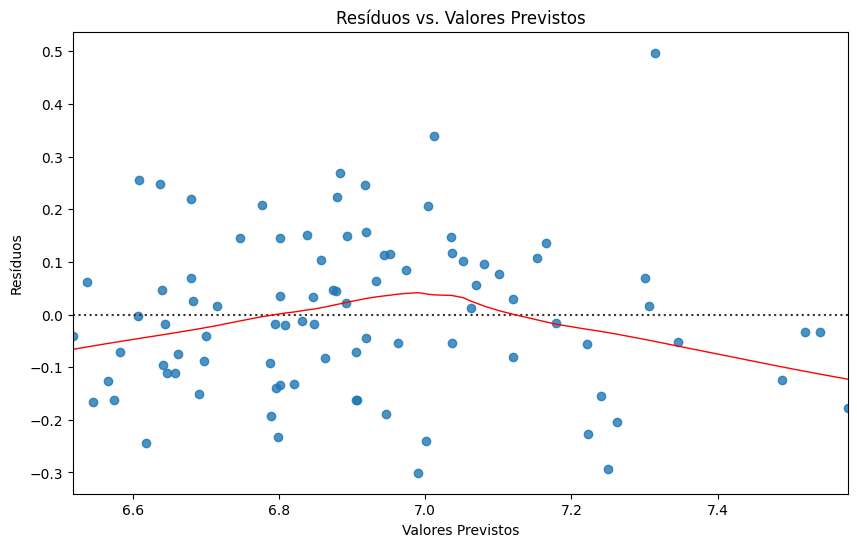

In [8]:
test_h2o = h2o.H2OFrame(X_test)
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE de {name}: {mse}")

y_pred_aml = aml.leader.predict(test_h2o).as_data_frame()['predict']
mse_aml = mean_squared_error(y_test, y_pred_aml)
print(f"MSE do H2O AutoML: {mse_aml}")

best_model = aml.leader if mse_aml < min([mean_squared_error(y_test, m.predict(X_test)) for m in best_models.values()]) else min(best_models.values(), key=lambda x: mean_squared_error(y_test, x.predict(X_test)))
residuals = y_test.reset_index(drop=True) - best_model.predict(test_h2o).as_data_frame()['predict']

plt.figure(figsize=(10, 6))
sns.residplot(x=best_model.predict(test_h2o).as_data_frame()['predict'], y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Resíduos vs. Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.show()

## Avaliação de desempenho dos modelos
A análise de erro quadrático médio (MSE) revelou que o modelo H2O AutoML alcançou o menor MSE de 0.02406, superando os outros modelos testados, Random Forest, SVM, Decision Tree e Linear Regression. Este resultado indica uma maior precisão do AutoML na previsão das avaliações dos jogadores, sugerindo que sua capacidade de ajuste automático de parâmetros e seleção de modelo é eficaz para este conjunto de dados.

## Análise Visual dos Resíduos
A plotagem dos resíduos versus valores previstos fornece insights cruciais sobre a adequação do modelo. A dispersão dos resíduos mostra que, embora a maioria dos erros esteja próxima de zero, existem alguns resíduos notavelmente mais altos ou mais baixos. Isso pode indicar casos específicos onde o modelo falha em capturar padrões subjacentes, possivelmente devido a variáveis atípicas ou anômalas não tratadas adequadamente.

A linha de tendência vermelha sugere uma variação sistemática nos resíduos em diferentes níveis de valores previstos, o que implica que o modelo pode ser melhorado para lidar com certas faixas de valores de forma mais eficiente. A análise detalhada desses padrões pode levar a um refinamento adicional do modelo, como ajustar os parâmetros do modelo, incorporar novas variáveis explicativas, ou aplicar transformações adicionais aos dados.

# Clustering
Aplicamos técnicas de clusterização para explorar padrões e agrupamentos entre os jogadores com base na precisão de passes e suas avaliações. Utilizando o método K-Means, identificamos grupos que compartilham características semelhantes, oferecendo uma perspectiva visual e quantitativa sobre como essas variáveis interagem e influenciam o desempenho dos jogadores no campo.

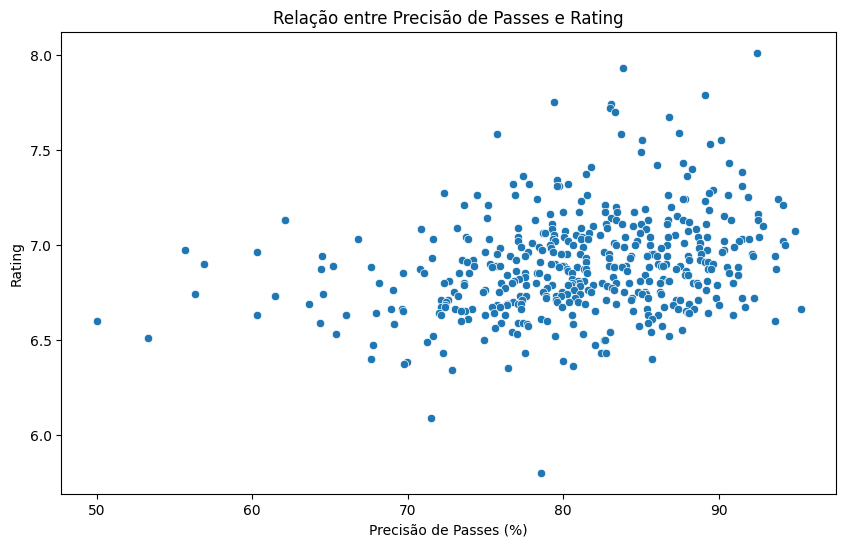

Correlação de Pearson entre Precisão de Passes e Rating: 0.29
MSE: 0.07, R2: 0.08


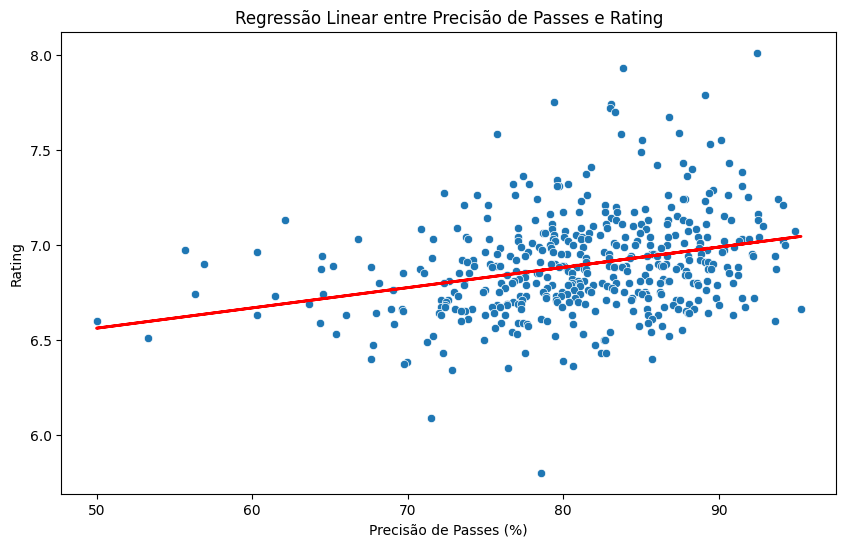

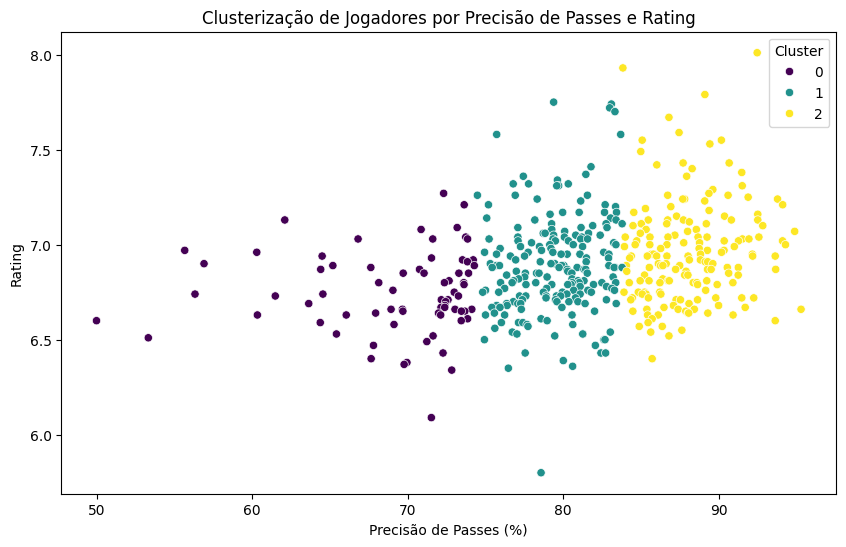

In [9]:
from sklearn.metrics import mean_squared_error, r2_score


# Análise exploratória
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accuratePassesPercentage', y='rating', data=df)
plt.title('Relação entre Precisão de Passes e Rating')
plt.xlabel('Precisão de Passes (%)')
plt.ylabel('Rating')
plt.show()

# Correlação
correlation = df['accuratePassesPercentage'].corr(df['rating'])
print(f'Correlação de Pearson entre Precisão de Passes e Rating: {correlation:.2f}')

# Regressão Linear
accurate_passes_X = df[['accuratePassesPercentage']]
rating_y = df['rating']
accurate_passes_model = LinearRegression()
accurate_passes_model.fit(accurate_passes_X, rating_y)
accurate_passes_pred = accurate_passes_model.predict(accurate_passes_X)

# Métricas de desempenho
mse = mean_squared_error(rating_y, accurate_passes_pred)
r2 = r2_score(rating_y, accurate_passes_pred)
print(f'MSE: {mse:.2f}, R2: {r2:.2f}')

# Plot da linha de regressão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accuratePassesPercentage', y='rating', data=df)
plt.plot(accurate_passes_X, accurate_passes_pred, color='red', linewidth=2)  # Adiciona a linha de regressão
plt.title('Regressão Linear entre Precisão de Passes e Rating')
plt.xlabel('Precisão de Passes (%)')
plt.ylabel('Rating')
plt.show()

# Clusterização com K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['accuratePassesPercentage', 'rating']])

# Visualização de Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accuratePassesPercentage', y='rating', hue='cluster', data=df, palette='viridis')
plt.title('Clusterização de Jogadores por Precisão de Passes e Rating')
plt.xlabel('Precisão de Passes (%)')
plt.ylabel('Rating')
plt.legend(title='Cluster')
plt.show()


 Podemos observar que há uma relação positiva, embora moderada, entre a precisão de passes dos jogadores e suas avaliações (rating), com uma correlação de Pearson de 0.29. Isso indica que, em média, quanto maior a precisão de passes de um jogador, melhor é sua avaliação. No entanto, a relação não é suficientemente forte para explicar uma grande parte da variação nos ratings, como evidenciado pelo baixo coeficiente de determinação (R² = 0.08) e pelo erro quadrático médio (MSE = 0.07).

A visualização da relação entre precisão de passes e rating mostra uma dispersão bastante ampla dos pontos, sugerindo que outros fatores além da precisão de passes também desempenham um papel significativo na determinação do rating de um jogador. A linha de regressão linear, embora ascendente, confirma que a relação, apesar de existir, não é fortemente preditiva.

A análise de clusterização, que agrupa os jogadores em três categorias com base em sua precisão de passes e rating, revela padrões interessantes. Os clusters parecem diferenciar grupos de jogadores com combinações distintas de precisão de passes e rating, mas não mostram uma separação clara baseada exclusivamente em alta precisão de passes levando a ratings mais altos. Isso sugere a complexidade e a multidimensionalidade das habilidades e desempenhos dos jogadores que impactam seu rating final.

# Análise Exploratória e Visualização Adicional
Inclui visualizações adicionais como a importância das características para fornecer insights adicionais sobre os dados e a importância das variáveis.

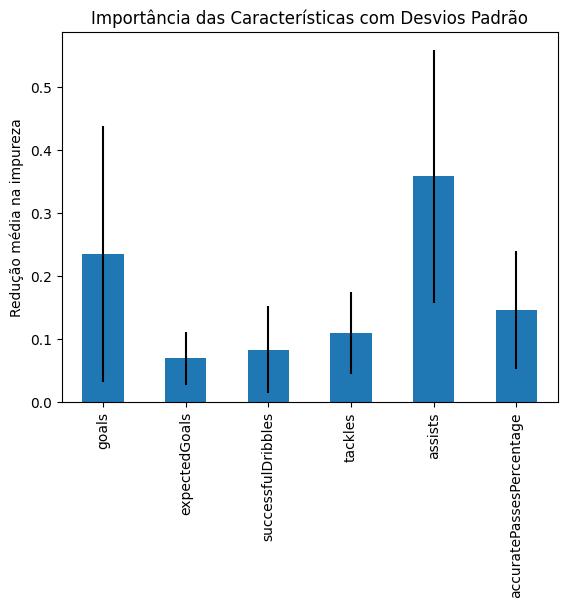

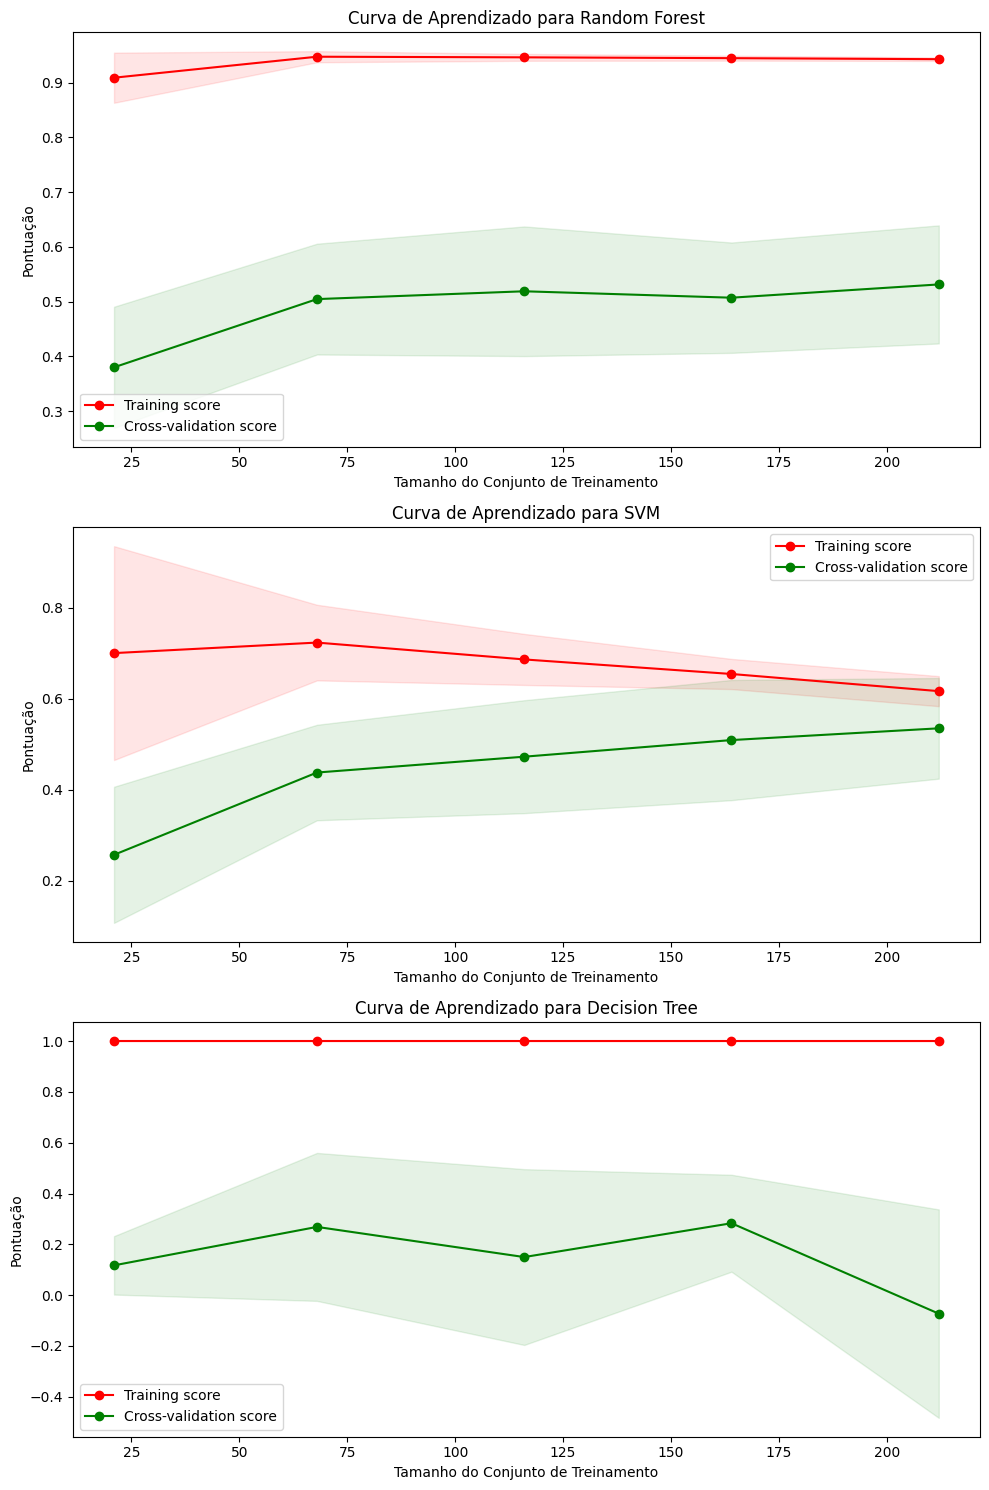

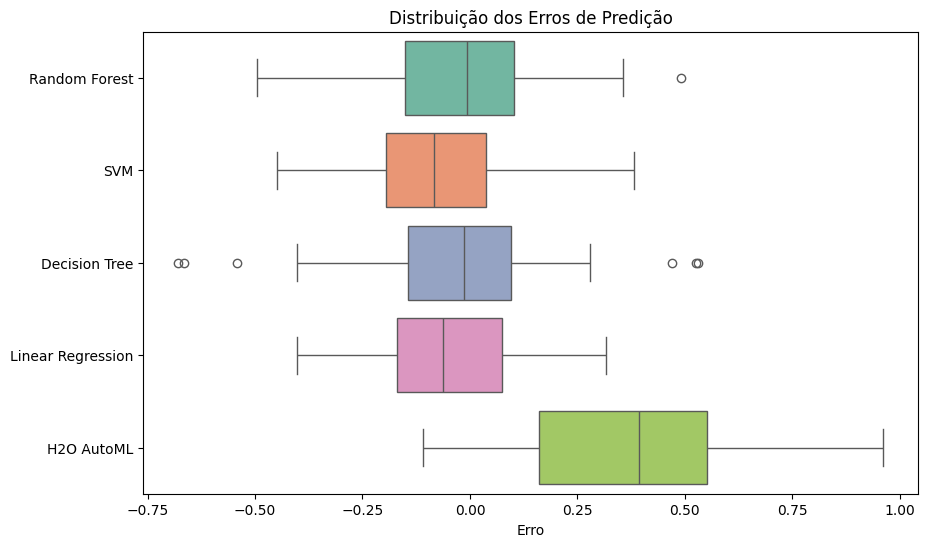

In [10]:
# Extração das importâncias das características do modelo Random Forest
importances = best_models['Random Forest'].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_models['Random Forest'].estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

# Criação de um gráfico de barras para visualizar a importância das características
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importância das Características com Desvios Padrão")
ax.set_ylabel("Redução média na impureza")
plt.show()

# Criação de gráficos de curva de aprendizado para cada modelo
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for ax, name, model in zip(axes, models.keys(), models.values()):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.set_title(f'Curva de Aprendizado para {name}')
    ax.set_xlabel('Tamanho do Conjunto de Treinamento')
    ax.set_ylabel('Pontuação')
    ax.legend(loc="best")
plt.tight_layout()
plt.show()

# Calculando os erros de predição para cada modelo
errors = {
    "Random Forest": y_test - best_models['Random Forest'].predict(X_test),
    "SVM": y_test - best_models['SVM'].predict(X_test),
    "Decision Tree": y_test - best_models['Decision Tree'].predict(X_test),
    "Linear Regression": y_test - best_models['Linear Regression'].predict(X_test),
    "H2O AutoML": y_test - y_pred_aml
}

# Visualização da distribuição dos erros de predição
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(errors), orient="h", palette="Set2")
ax.set_title('Distribuição dos Erros de Predição')
ax.set_xlabel('Erro')
plt.show()



## 1. Importância das Características
O destaque da característica 'assists' (assistências) na análise da importância das características sugere que a habilidade de um jogador em contribuir com passes decisivos para gols é extremamente valorizada ao prever o 'rating' no futebol. Esse resultado destaca a importância das habilidades colaborativas sobre as individuais, indicando que jogadores que facilitam oportunidades para outros tendem a ser mais valorizados. Tal insight pode orientar treinadores e recrutadores a focar em habilidades de visão de jogo e passe durante treinamentos e avaliações, promovendo um estilo de jogo que beneficie toda a equipe.

## 2. Curvas de Aprendizado
As curvas de aprendizado para cada modelo mostraram como cada um responde ao aumento do número de amostras de treinamento. O modelo Random Forest e SVM mostraram um desempenho consistente e melhorado à medida que mais dados eram fornecidos, indicando boa generalização e capacidade de aprendizado. Por outro lado, a Curva de Aprendizado para Decision Tree mostrou uma convergência de desempenho entre os scores de treinamento e validação, sugerindo um possível overfitting com conjuntos de treinamento menores.

## 3. Distribuição dos Erros de Predição
O diagrama de caixa mostra a distribuição dos erros de predição para cada modelo. H2O AutoML apresenta os erros mais centralizados em torno de zero, indicando uma maior precisão nas previsões em comparação com os outros modelos. Modelos como a Árvore de Decisão e o SVM mostram maior variação nos erros, o que sugere menor consistência em suas previsões.